# Chapter 5: Causal Structure Learning from Data

In the previous chapter, we build a causal model knowing the equation structure of the problem from our domain knowledge. However, we do not have the privilege of knowing causal structure in the real world.


In this chapter, our goal is to create a causal model without knowing the causal structure of the problem. In other words, our problem is the **causal structure identification or discovery**. So, we have two major steps:


Incorporating prior knowledge is always a big help to causal discovery algorithms.


## How can we discover a causal structure from a dataset without domain knowledge?

Causal structure identification or discovery can be challenging, especially when you have no prior knowledge or domain expertise about the dataset. In addition, it is an ongoing field of research, and there are limitations and challenges involved in inferring causal relationships from observational data alone. 

However, some methods and approaches can be employed to uncover causal relationships in such situations. Such methods can be divided into different categories. However, the two main groups are **Independence-Based Methods** and **Score-Based Methods**. We will explain them in more detail as follows.




## A. Independence-Based Methods

Independence-based methods assume that the distribution is faithful to the underlying causal DAG. 

- In orher workds, there is a one-to-one correspondence between d-separationsin the graph and conditional independences in the distribution of the data.  

- Any query of a d-separation statement can therefore be answered by checking the corresponding conditional independence test. 

Independence-based methods test for conditional independences in the data. 

- These properties are related to the graph structure by the Markov condition and faithfulness.
- However,often the graph is not uniquely identifiable; the method may therefore output different graphs for the same dataset.


The figure below summarizes the independence-based approaches for the identification of causal structures. 

![img](img/ch6/independence_tests.png)


Most independence-based methods first estimate the skeleton, the undirected edges, and then orient as many edges as possible afterward.

#### Step 1: Estimation of the skeleton

- knowing which variables are connected by an arrow but not what direction the arrows point.

- Two nodes $X,Y$ in a DAG $(\mathbf{X},\mathcal{E})$ are adjacent if and only if they cannot be d-separated by any subset $S \in \mathbf{V} \ {X,Y}$.

- If two nodes $X,Y$ in a DAG $(\mathbf{X},\mathcal{E})$ are not adjacent, then they are d-separated by either $\mathbf{Pa}_X$ or $\mathbf{Pa}_Y$.

It follows that if two variables are always dependent, no matter what other variables one conditions on, these two variables must be adjacent (i.e., an edge must connect them).

#### Step 2: Orientation of Edges

- After the skeleton is built, if two nodes are not directly connected in the obtained skeleton, there is a set that d-separates these nodes. 

- Often, we’ll only be able to orient some arrows. 

- The ambiguity of the directions of other arrows generates a class of causal structures, e.g. a markov equavalnt class.


**Inductive Causation (IC)** [algorithm](https://www.ics.uci.edu/~dechter/courses/ics-295cr/spring-2021/reading/Theory_of_Inferred_Causation_R156.pdf), the **Spirtes-Glymour-Scheines (SGS)** [algorithm](https://people.cs.umass.edu/~mccallum/courses/gm2011/22-causality.pdf), and the **Peter-Clark (PC)** [algorithm](https://proceedings.mlr.press/v89/tu19a/tu19a.pdf) (named after Peter Spirtes and Clark Glymour) are famous independence-test based algorithms. 

<br>

### Peter-Clark (PC) Algorithm:

**Step 1:** form a fully connected, undirected graph using every variable in the dataset (Fig. B). 

**Step 2:**  edges are deleted if the corresponding variables are independent (Fig. C). 

**Step 3:**  connected edges undergo conditional independence testing. If conditioning on a third variable kills the dependence between two variables, links are deleted between those two variables (Fig. D).

**Step 4:**  colliders are oriented based on the d-separation sets (Fig. E). 

**Step 5:**  remaining edges are directed based on two constraints (Fig. F), 
- 1) no new v-structures and 
- 2) no directed cycles can be formed.

An outline of the PC algorithm is illustrated in the figure below (image taken from [here](https://www.frontiersin.org/articles/10.3389/fgene.2019.00524/full)). 

![img](img/ch6/PC-Method.png)


## B. Score-based Methods

Independent-based causal discovery methods rely on conditional independence tests, which assume faithfulness between the DAG and the data. However, this assumption is quite strong, and obtaining reliable conditional independence tests may require large sample sizes. Additionally, the outcome of Independent-based causal discovery methods is often non-unique, meaning that multiple graph structures can fit the data equally well.


Alternatively, Score-based methods for causal discovery are approaches that aim to identify causal relationships by evaluating the fit or goodness-of-fit of different causal models to the observed data. 

These score-based methods assign scores to different causal structures based on how well they explain the data, and the structure with the highest score is considered the most likely causal model. 


Score-based Methods for causal discovery have two main components:

*   a) **Search Algorithm** to optimize throughout the search space of all possible DAGs (e.g. *Hill Climb Search, Exhaustive Search, and Chow-Liu*)


*   b) **Scoring Function** to measure how well a Bayesian network fits the data. Commonly used scoring functions are *K2* and the *Bayesian Information Criterion (BIC)*.


Given a dataset $\mathcal{D} = (X^1,\dots,X^n)$ from a vector $X$ of variables (e.g., a sample containing $n$ i.i.d. observations), the idea is to assign a score $S(\mathcal{D}, \mathcal{G})$ to each graph $\mathcal{G}$ and search over the space of DAGs to find the graph with the highest score:

$$\hat{ \mathcal{G} } = argmax_\mathcal{ \{G\} } S(\mathcal{D},\mathcal{G})$$



### a) Search Algorithms

A search algorithm is used to explore the graph space (i.e., the set of all possible graphs given the nodes) to maximize (or minimize) the given score function. 

The choice of search method depends on various factors, including the size of the variable set, computational resources, and specific requirements of the causal discovery task. Different search methods have their strengths and limitations in terms of computational efficiency, accuracy, and ability to handle large-scale problems.

Following are some examples of search methods used in causal discovery. 


**Exhaustive Search:**  

- Exhaustive search is a straightforward but computationally intensive method that evaluates all possible causal structures within a given set of variables. 
- It systematically examines every combination of directed edges and evaluates their fit using the scoring criterion. 
- However, exhaustive search becomes infeasible for large variable sets due to the exponential growth of possible structures.


**Greedy Search Techniques:**

- Greedy search methods iteratively build causal structures by adding or removing edges based on their impact on the score.
- They start with an initial structure, such as an empty graph, and iteratively modify it to improve the score. 
- The search terminates once a local maximum is found, i.e. adding other edges would not increase the score associated to the model.
- Popular greedy search algorithms include the Hill-Climbing algorithm and its variants. 
- Greedy searches reach to a local optimum and cannot guarantee an optimal solution. 

**Metaheuristic Search:**

- Metaheuristic search methods, such as genetic algorithms, particle swarm optimization, or simulated annealing, employ stochastic optimization techniques to explore the space of possible causal structures. 
- These methods use iterative processes that involve randomly perturbing or modifying existing structures and selecting or refining the best-fitting structures based on the scoring criterion.



### b) Scoring Functions

Scoring functions $S$, also known as scoring criteria or scoring metrics, are used in score-based causal discovery approaches to evaluate and compare the fit of different causal structures to the observed data, with higher scores indicating better fit.


Here are some commonly used scoring functions in score-based causal discovery:

**Bayesian Information Criterion (BIC):** 

- The BIC scoring function is based on the principle of maximum likelihood estimation (MLE) and takes into account both the likelihood of the data and the number of parameters in the model.
- BIC penalizes more complex models to avoid overfitting and favors simpler models that still provide a good fit to the data.
- the BIC scoring function is often used in combination with search algorithms, such as hill climbing or genetic algorithms, to explore and evaluate different causal structures. 
- BIC for data $\mathcal{D}$ and graph $\mathcal{G}$ defines as:

$$BIC(\mathcal{D},\mathcal{G}) = -2 * log(L) + k * log(n)$$

where $L$ is the likelihood of the data given the causal model, $k$ is the number of parameters in the model, and $n$ is the sample size. The first term ($-2 * log(L)$) represents the fit of the model to the data, with lower values indicating a better fit. The second term ($k * log(n)$) penalizes the model complexity.


**Akaike Information Criterion (AIC):**

- Like the BIC (Bayesian Information Criterion), the AIC is a measure that balances the goodness-of-fit of a model to the data with the complexity of the model.
- The AIC scoring function is derived from information theory and is based on the principle of maximum likelihood estimation (MLE). 
- It evaluates the fit of a model by considering both the likelihood of the data and the number of parameters in the model. 
- AIC for data $\mathcal{D}$ and graph $\mathcal{G}$ defines as:

$$AIC(\mathcal{D},\mathcal{G}) = -2 * log(L) + 2 *k$$

where $L$ is the likelihood of the data given the causal model, and $k$ is the number of parameters in the model. In the AIC score, the first term ($-2 * log(L)$) represents the fit of the model to the data, with lower values indicating a better fit. The second term ($2 * k$) penalizes the model complexity. 

Unlike the BIC, which includes a penalty factor that increases with the sample size, the AIC penalty term is a fixed factor of 2 multiplied by the number of parameters.



**Bayesian Scoring Criterion (BS):** 

- The Bayesian score function, also known as the Bayesian scoring criterion or the Bayesian information score, incorporates Bayesian principles and probabilities to evaluate the fit of different causal structures to the observed data.

- The Bayesian score function considers both the likelihood of the data given the causal model and the prior probability of the model itself. 

- It assigns scores to different causal structures based on their posterior probabilities, which are obtained by combining the prior probabilities and the likelihoods.

- The structure with the highest Bayesian score is considered the most plausible model.

- The Bayesian score function can be written as:

$$BS(\mathcal{D},\mathcal{G}) = log P(\mathcal{D} , \mathcal{G}) = log (P(\mathcal{D} | \mathcal{G}) * P(\mathcal{G})) = log P(\mathcal{D} | \mathcal{G}) + log P(\mathcal{G})$$

where $log P(\mathcal{D} | \mathcal{G})$ represents the likelihood of the observed data given the causal model, and $P(\mathcal{G})$ represents the prior probability of the model.

The **likelihood term** $log P(\mathcal{D} | \mathcal{G})$ assesses how well the model explains the observed data. It evaluates the fit of the model by considering the probability distribution implied by the model and comparing it to the actual data.

The **prior probability term** $P(\mathcal{G})$ represents prior knowledge or assumptions about the probability of each causal structure. It encodes beliefs or expectations about the plausibility of different structures before observing the data.


It's important to note that the Bayesian score function requires prior probabilities, which can be based on expert knowledge or can be specified using non-informative priors. The choice of prior probabilities may influence the results, and different choices can lead to different model selections.



### c) Other Causal Discovery Methods


Causal discovery methods can be categorized into several different approaches based on the underlying principles and techniques they employ. We explaned two major approaches, **Independence-Based Methods** and **Score-Based Methods**.

Other common approaches are:

**Information-Theoretic Methods:** 

- Information-theoretic methods employ principles from information theory to discover causal relationships. These methods measure the amount of information shared between variables to infer causal dependencies. 
- Examples of information-theoretic methods include **Mutual Information**, **Transfer Entropy**, and **Granger Causality**.

[Here](https://sites.google.com/view/itci22) is the proccesing of the AAAI 2022 Workshop on Information-Theoretic Methods for Causal Inference and Discovery. Nice papers!

**Machine Learning Methods:**

- Machine learning-based approaches use advanced algorithms and models to learn causal relationships from data. 
- These methods often involve training predictive models, such as Bayesian networks, structural equation models, or causal Bayesian networks, to estimate causal relationships. - -- Machine learning methods for causal discovery include methods based on neural networks, decision trees, random forests, etc.

We recommend you to check Chapter 4 and 7, Learning Cause-Effect Models from the [Elements of Causal Inference](https://mitpress.mit.edu/books/elements-causal-inference) book to learn more abo0ut ML based causal discovery methods.

Also, the [Machine Learning for Causal Inference in Biological Networks: Perspectives of This Challenge](https://www.frontiersin.org/articles/10.3389/fbinf.2021.746712/full) provides a nice overview on such ML-based methods.


## Do you want to know more about causal discovery methods?


A broad overview of different causal structure search methods is available at:
[Review of Causal Discovery Methods Based on Graphical Models](https://www.frontiersin.org/articles/10.3389/fgene.2019.00524/full#:~:text=Causal%20discovery%20aims%20to%20find,process%20or%20the%20sampling%20process). This paper is written by Clark Glymour and Peter Spirtes who are two frontiers in the causal inference theory.


Finally, **structure learning is an active field of research.** These algorithms don't guarantee to retrieve the true causal relationship for all the variables. However, they can help better understand the problems and some relationships between variables. 

## Example for Causal Structure Learning : Shortness of Breath Disease

In this example we will try to analyse patients treatment regarding shortness-of-breath (dyspnoea). The dataset has few variables and is siumulated by [Lauritzen and Spiegelhalter,1988](https://www.jstor.org/stable/2345762?seq=1). The data is about relationship between lung diseases (tuberculosis, lung cancer or bronchitis) and visits to infection areas for 20000 patientes.

### Background:

- Shortness-of-breath (dyspnoea) may be due to **tuberculosis, lung cancer, bronchitis**, or none of them, or more than one of them. 

- We asume that a visit to an infectious area increases the chances of tuberculosis, while smoking is known to be a risk factor for both lung cancer and bronchitis. 

- The results of a single chest X-ray do not discriminate between lung cancer and tuberculosis, as neither does the presence or absence of dyspnoea.


**What is the causal model for the dyspnoea based on the Lauritzen and Spiegelhalter dataset?**

To solve this problem, we will make use of the *bnlearn* and *pgmpy* library, which are a Python implementation for Bayesian Networks with various algorithms for Structure Learning, Parameter Estimation, Approximate (Sampling Based), and Causal Inference.


### Import Data and Ground Truth


In [1]:
import utils
df = utils.generate_dyspnoea_dataset()
# Save the DataFrame in case
# df.to_csv("dyspnoea.csv", index=False)

[bnlearn] >bayes DAG created.
[bnlearn] >Extracting files..


Generating for node: dysp: 100%|██████████| 8/8 [00:00<00:00, 225.81it/s]


[bnlearn] >Forward sampling for 20000 samples..


Generating for node: dysp: 100%|██████████| 7/7 [00:00<00:00, 138.71it/s]


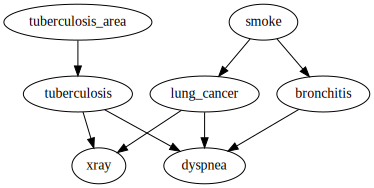

In [2]:
ground_truth = utils.plot_dyspnoea_dataset(mode = "graphviz")
ground_truth

This is the 'ground truth', which is the model that generates the data. Let's see if we can retrieve it back from the data (this is where the **causal structure learning** can help us). 

Here are few rows of the data:


In [2]:
# Load model
import bnlearn as bn
import pandas as pd

df = pd.read_csv('data/dyspnoea.csv')
df.head()

,tuberculosis_area,tuberculosis,dyspnea,xray,lung_cancer,smoke,bronchitis
0,1,1,1,1,1,0,1
1,1,1,1,1,1,0,1
2,1,1,0,1,1,0,0
3,1,1,0,1,1,0,0
4,1,1,0,1,1,0,0


## Scenario 1: Build a causal model when we have data and domain knowledge

As we saw in the lectures, expert knowledge can be included in causal models by using graphs in the form of a Directed Acyclic Graphs. 

Let's assume that our knowledge about dyspnoea is limited to: smoking is related to lung cancer, smoking is related to bronchitis, and if you have lung or bronchitus we may need an x-ray examination. 

Therefore, we create a DAG based on this knowledge:

[bnlearn] >bayes DAG created.


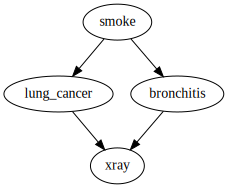

In [3]:
import graphviz as gr
import bnlearn as bn

edges = [('smoke', 'lung_cancer'),
         ('smoke', 'bronchitis'),
         ('lung_cancer', 'xray'),
         ('bronchitis', 'xray')]

# Create the DAG from the edges
DAG = bn.make_DAG(edges)

g = utils.plot_from_edges(edges)
g

<br/><br/>

At this point, we have the data set in our dataframe (df) and the DAG based on our expert knowledge. 

We can use parameter learning to learn conditional probability distributions (CPDs) of variables in our model using a Baysian method. 


In [4]:
# Learn the parameters from data set.
# As input we have the DAG without CPDs.
DAG = bn.parameter_learning.fit(DAG, df, methodtype='bayes')

[bnlearn] >Removing columns from dataframe to make consistent with DAG [['tuberculosis_area' 'tuberculosis' 'dyspnea']]
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >CPD of smoke:
+----------+----------+
| smoke(0) | 0.498143 |
+----------+----------+
| smoke(1) | 0.501857 |
+----------+----------+
[bnlearn] >CPD of lung_cancer:
+----------------+---------------------+---------------------+
| smoke          | smoke(0)            | smoke(1)            |
+----------------+---------------------+---------------------+
| lung_cancer(0) | 0.15772870662460567 | 0.07268241768668754 |
+----------------+---------------------+---------------------+
| lung_cancer(1) | 0.8422712933753943  | 0.9273175823133124  |
+----------------+---------------------+---------------------+
[bnlearn] >CPD of bronchitis:
+---------------+---------------------+--------------------+
| smoke         | smoke(0)            | smoke(1)           |
+---------------+---------------------+------

We can print CPD that we calculated.

We also check the independencies from the DAG and calculated CPD.

In [5]:
# Print the CPDs
bn.print_CPD(DAG)
# At this point we have a DAG with the learned CPDs

CPD of smoke:
+----------+----------+
| smoke(0) | 0.498143 |
+----------+----------+
| smoke(1) | 0.501857 |
+----------+----------+
CPD of lung_cancer:
+----------------+---------------------+---------------------+
| smoke          | smoke(0)            | smoke(1)            |
+----------------+---------------------+---------------------+
| lung_cancer(0) | 0.15772870662460567 | 0.07268241768668754 |
+----------------+---------------------+---------------------+
| lung_cancer(1) | 0.8422712933753943  | 0.9273175823133124  |
+----------------+---------------------+---------------------+
CPD of bronchitis:
+---------------+---------------------+--------------------+
| smoke         | smoke(0)            | smoke(1)           |
+---------------+---------------------+--------------------+
| bronchitis(0) | 0.585125704999522   | 0.3266913369389885 |
+---------------+---------------------+--------------------+
| bronchitis(1) | 0.41487429500047796 | 0.6733086630610114 |
+---------------+---

Now we can combined our expert knowledge with the data set! 

Then we can make inferences which allows us to ask causal questions from the model. Let us demonstrate a few questions...

<br>

**Question 1:**

**What is the probability of lung-cancer, given that we know that patient does smoke $P(Lung-Cancer | smoke)$?**

In [6]:
q1 = bn.inference.fit(DAG, variables=['lung_cancer'], evidence={'smoke':1})

[bnlearn] >Variable Elimination..


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+----+---------------+-----------+
|    |   lung_cancer |         p |
+====+===============+===========+
|  0 |             0 | 0.0726824 |
+----+---------------+-----------+
|  1 |             1 | 0.927318  |
+----+---------------+-----------+


<br/><br/>

**Question 2:**

**What is the probability of bronchitis, given that we know patient does smoke $P(bronchitis | smoke)$?**

In [7]:
q2 = bn.inference.fit(DAG, variables=['bronchitis'], evidence={'smoke':1})

[bnlearn] >Variable Elimination..


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+----+--------------+----------+
|    |   bronchitis |        p |
+====+==============+==========+
|  0 |            0 | 0.326691 |
+----+--------------+----------+
|  1 |            1 | 0.673309 |
+----+--------------+----------+


<br/><br/>

**Question 3:** 

**What is the probability of lung-cancer, given that we know that patient does smoke and also has bronchitis $P(lung-cancer | bronchitis, smoke)$?**

In [8]:
q3 = bn.inference.fit(DAG, variables=['lung_cancer'], evidence={'smoke':1, 'bronchitis':1})

[bnlearn] >Variable Elimination..


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+----+---------------+-----------+
|    |   lung_cancer |         p |
+====+===============+===========+
|  0 |             0 | 0.0726824 |
+----+---------------+-----------+
|  1 |             1 | 0.927318  |
+----+---------------+-----------+


<br/><br/>

**Question 4:**

**What is the probability of lung-cancer or bronchitis, given that we know that patient does smoke but did not had xray?**

In [9]:
q4 = bn.inference.fit(DAG, variables=['bronchitis','lung_cancer'], evidence={'smoke':1, 'xray':0})

[bnlearn] >Variable Elimination..


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+----+--------------+---------------+----------+
|    |   bronchitis |   lung_cancer |        p |
+====+==============+===============+==========+
|  0 |            0 |             0 | 0.122772 |
+----+--------------+---------------+----------+
|  1 |            0 |             1 | 0.206891 |
+----+--------------+---------------+----------+
|  2 |            1 |             0 | 0.247476 |
+----+--------------+---------------+----------+
|  3 |            1 |             1 | 0.422862 |
+----+--------------+---------------+----------+


## Scenario 2: Build a causal model when we have data, but no domain knowledge!

Suppose that we have the medical records of hundreds or even thousands patients treatment regarding shortness-of-breath (dyspnoea). 

Our goal is to determine the causality across variables given the data set. 

We dont have a prior knowledge. e.g. we are a data scientist whom just start to work with the dataset.

We use a causal discovery method such as PC to estimate the DAG structure of the dataset.

### Causal Discovery with a Indepence-based Method:

#### PC Algorithm 

As we saw the PC algorithm is based on independence-based method that creates a DAG by querying the dataset for d-separation statements and by checking the corresponding conditional independence test.

In [1]:
from pgmpy.estimators import PC, HillClimbSearch, MmhcEstimator
from pgmpy.estimators import K2Score
import bnlearn as bn
import utils
import graphviz as gr
import pandas as pd

In [2]:
df = pd.read_csv("data/dyspnoea.csv")

Working for n conditional variables: 4:  80%|████████  | 4/5 [00:00<00:00,  8.65it/s]


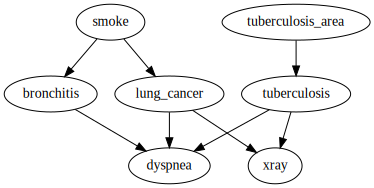

In [33]:
est = PC(data = df)
estimated_model = est.estimate(variant="stable", max_cond_vars=5, ci_test = "chi_square", return_type = "dag", significance_level = 0.01)
utils.plot_from_model_pgmpy(estimated_model.edges())

We see that the graph has been correclty identified.

We recall that the ground truth is:

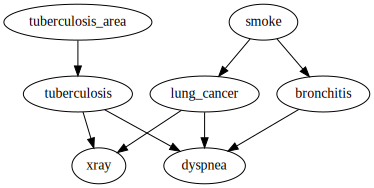

In [14]:
ground_truth

### Causal Discovery with a Score-based Method:

As we saw, Score-based Methods test different graph structures in their ability to fit the data.  

- In this problem, we use an Exhaustive and Hill-climb search methods. However, the library has other search methods too.
- We use BIC and K2 Score functions.  However, the library has other scores too.

Here is the [documentation](https://erdogant.github.io/bnlearn/pages/html/bnlearn.structure_learning.html) page for the **bnlearn library** regarding its various search methods and score functions. 


In [ ]:
# Search method = Exhaustive search
# Score functions: BIC
model_estimated = bn.structure_learning.fit(df, methodtype='ex', scoretype='bic')
# After 8 minutes the code was still running, compared to 0.6s of the previous approach. Therefore it is here presented only for completeness

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [k2]


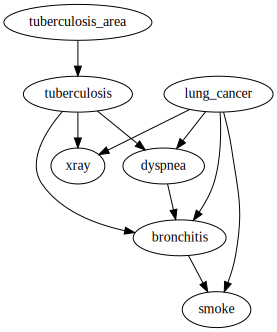

In [15]:
# Search method = Hill-climb search
# Score functions: K2
estimated_model_k2 = bn.structure_learning.fit(df, methodtype='hc', scoretype='k2')
utils.plot_from_model_bnlearn(estimated_model_k2)

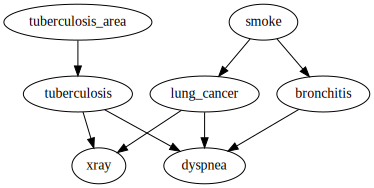

In [29]:
ground_truth

Finally, we can compare the different causal graphs that we discovered with the ground truth: 

![img](img/ch6/causal_structure_comparison.png)


**Which one is better?**

It is important to bear in mind that these algorithms don't guarantee to retrieve the true causal relationship for all the variables (otherwise causal inference would be easy to perform). 
However, they can help better understand the problems and some relationships between variables. 

### References
For this chapter, we used an exmaple from *bnlearn - Library for Bayesian network learning and inference*. The e-book has varius exmaples with nice visualization. Here is the ptython library [bnlearn](https://pypi.org/project/bnlearn/)

The Python bnlearn ieself is inspired by the [bnlearn - an R package for Bayesian network learning and inference](https://www.bnlearn.com) book an amazing work by Marco Scutari, IDSIA.
